# Install

In [2]:
! pip install memory_profiler
%load_ext memory_profiler 

Defaulting to user installation because normal site-packages is not writeable


# Import 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn  # Speeds up sklearn with intel patch
patch_sklearn()  # Activate patch - changes sklearn imports below

from timeit import default_timer as timer # Time how long commands take
from sklearn.model_selection import train_test_split, StratifiedKFold  # test_train split, cross-validation

from sklearn.experimental import enable_iterative_imputer  # Iterative imputer experimental so need to enable it
from sklearn.impute import IterativeImputer  # Once enabled iterative imputer can be imported

from sklearn.linear_model import RidgeClassifier, BayesianRidge  # Imputation
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder  # Normalisation & Encoding
from imblearn.under_sampling import TomekLinks, RandomUnderSampler   # Undersampling
from imblearn.over_sampling import SMOTENC  # Oversampling
from sklearn.feature_selection import RFE, RFECV  # Recursive feature elimination - feature selection
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier  # RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.model_selection import validation_curve

import pickle
import shap

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Variables 

In [4]:
# Number of cores being used 
n_jobs = 10

In [5]:
# Random State
random_state = 14

# General Functions

In [6]:
# Stopwatch to profile function runtimes
class Stopwatch:

    # Initiate constructor
    def __init__(self):
        self.start = timer()
        self.end = None
        self.runtime = None

    # Stop stopwatch
    def stop(self):
        self.end = timer()
        self.runtime = self.end - self.start
        return self.runtime

In [7]:
# Find which columns are categorical and which continuous
def cat_con_cols(df):
    
    columns = [list(df[i]) for i in df]  # Nested list of column values
    num_unique_vals = [len(set([i for i in a if pd.notna(i)])) for a in columns]  # Num of unique values in a column

    categorical_indexes = [i for i, v in enumerate(num_unique_vals) if v <= 100
                           and set([a % 1 for a in df[df.columns[i]].dropna()]) == {0}]

    continuous_indexes = [i for i, v in enumerate(num_unique_vals) if v > 100 or
                          set([a % 1 for a in df[df.columns[i]].dropna()]) != {0}]

    cat = list(df.columns[categorical_indexes])
    con = list(df.columns[continuous_indexes])
    return cat, con

# Data Cleaning

In [8]:
# Read in data
df = pd.read_csv('/data/home/bt211037/dissertation/no_leakage_data.tsv',
                   sep='\t', header=0, index_col=0)

### Convert categorical columns to integers 

In [9]:
# Get the column names of the continuous and categorical data
cat, con = cat_con_cols(df)  

# Convert categorical cols values from floats to integers 
df[cat] = df[cat].astype('Int64')  

### Separate categorical and Continuous features in dataframe

This makes indexing certain features in later processess easier. Continuous features are the first columns followed by categorical.


In [10]:
# Column indexes for categorical and continuous features
# Important to exclude target feature - thryoid_cancer
categorical_indexes = [i for i, x in enumerate(df.columns[0:374]) if x in cat]
continuous_indexes = [i for i, x in enumerate(df.columns) if x in con]


# Test Train Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'thyroid_cancer'],
                                                        df['thyroid_cancer'],
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=random_state,
                                                        stratify=df['thyroid_cancer'])


# Pipeline Components


### Imputation

- Simple
- KNN
- Multiple

In [12]:
# Simple imputer 
simp_imputer = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(missing_values=np.nan, strategy='median'),
             continuous_indexes),

            ('cat', SimpleImputer(missing_values=np.nan, strategy='constant',
                                  fill_value=4444),
             categorical_indexes)

        ])


In [13]:
# KNN imputer
knn_imp = KNNImputer(n_neighbors=1)

In [14]:
# Multiple imputation with iterative imputer
imputer = ColumnTransformer(
    transformers=[
        ('num', IterativeImputer(initial_strategy='median',
                                 max_iter=5,
                                 random_state=random_state), 
         continuous_indexes),
        
        ('cat', IterativeImputer(estimator=RidgeClassifier(),
                                 initial_strategy='most_frequent',
                                 max_iter=10, 
                                 random_state=random_state), 
         categorical_indexes)
    
    ])


### Sampling Methods
Tomek Links Undersampling and SMOTENC oversampling will be used to address class imbalance. This will be compared with using no sampling methods.

In [15]:
# Tomek Links undersampling
tl = TomekLinks(sampling_strategy='majority')

In [16]:
# SMOTE oversampling
smote = SMOTENC(random_state=random_state,
                categorical_features=categorical_indexes,
                sampling_strategy=1)

### Predictive model

In [17]:
# ExtraTrees Model 
et_model = ExtraTreesClassifier(n_jobs=n_jobs, 
                                random_state=random_state)

# Random undersampling for hyperparamter tuning

Undersample the majority class in the dataset to provide a smaller dataset for hyperparamter tuning. Training on this smaller dataset even seems to give better results than on the full dataset.

Reduces the data from ~300,000 to ~6,000 rows/samples.

In [18]:
# Configure random undersampler
rus = RandomUnderSampler(sampling_strategy=0.1,
                         random_state=random_state)


In [19]:
# Create the dataset used for hyperparamter tuning and training
X_res, y_res = rus.fit_resample(X_train, y_train.astype('float64'))


In [20]:
X_res

,Weight method|x21_0_0,Spirometry method|x23_0_0,Year of birth|x34_0_0,Hand grip strength (left)|x46_0_0,Hand grip strength (right)|x47_0_0,Waist circumference|x48_0_0,Hip circumference|x49_0_0,Standing height|x50_0_0,Month of birth|x52_0_0,UK Biobank assessment centre|x54_0_0,...,Triglycerides|x30870_0_0,Urate|x30880_0_0,Vitamin D|x30890_0_0,Unadjusted T/S ratio|x22190_0_0,Adjusted T/S ratio|x22191_0_0,Z-adjusted T/S log|x22192_0_0,Creatinine (enzymatic) in urine|x30510_0_0,Potassium in urine|x30520_0_0,Sodium in urine|x30530_0_0,medication_cbi
0,1,<NA>,1946,14,16,79.0,99.0,163.1,7,9,...,1.447,244.1,25.0,0.595666,0.681698,-1.213270,7180.0,82.6,64.1,-1
1,1,0,1945,24,30,87.0,90.0,174.0,12,7,...,1.395,349.1,28.1,0.622204,0.671039,-1.315270,5908.0,57.7,63.1,-1
2,1,0,1941,20,20,68.0,101.0,155.0,7,13,...,0.753,265.3,79.2,0.669919,0.785456,-0.296245,3697.0,54.1,31.6,-1
3,1,0,1947,20,22,68.0,99.0,159.0,4,16,...,0.914,226.8,77.8,0.692000,0.747990,-0.612592,2953.0,19.7,27.0,-1
4,1,<NA>,1945,18,22,92.0,102.0,166.0,1,6,...,2.187,251.4,50.8,0.775173,0.860506,0.294415,6298.0,46.4,72.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034,1,0,1949,22,28,69.0,89.0,160.0,9,20,...,1.155,202.6,65.2,0.814841,0.943346,0.889329,5225.0,38.8,104.1,-1
6035,1,0,1952,22,26,68.0,90.0,158.0,7,7,...,0.832,224.2,22.8,0.720588,0.807258,-0.119031,7404.0,41.3,114.6,-1
6036,1,0,1944,12,20,75.0,88.0,158.0,9,8,...,1.379,378.5,48.2,0.627045,0.773057,-0.399232,2878.0,19.9,16.9,1
6037,1,0,1967,20,28,60.0,88.0,153.0,10,20,...,0.649,238.0,26.0,0.777690,0.926021,0.769352,8685.0,62.9,158.0,-1


# Hyperparameter tuning

### KNN imputation

In [20]:
# extra trees classifier pipeline with knn imputation
pipeline = imbpipeline(steps = [('imputer', knn_imp),
                                    ('tomek', tl),
                                    ('smotenc', smote),
                                    ('model', et_model)])

In [21]:
# Parameter to search
search_grid = {'model__n_estimators': [100, 200, 500],
               'model__max_features': [5, 10, 15, 20, 40],
               'model__max_depth': [5, 10, 15, 20],
               'model__bootstrap': [True, False]}

In [22]:
# Random search configurations
search = GridSearchCV(estimator=pipeline,
                      param_grid=search_grid,
                      cv=3,
                      n_jobs=n_jobs,
                      scoring='f1')

In [23]:
%%memit

t=Stopwatch()

search.fit(X_res, y_res)

print(t.stop())

1646.0245627649128
peak memory: 3434.56 MiB, increment: 788.61 MiB


In [24]:
# Look at results of search
search_results = pd.DataFrame(search.cv_results_)

In [25]:
# Find the optimum number of features
search.best_params_

{'model__bootstrap': True,
 'model__max_depth': 5,
 'model__max_features': 5,
 'model__n_estimators': 100}

In [26]:
# Best score
search.best_score_

0.15018233857919203

### Simple Imputation

In [33]:
# extra trees classifier pipeline with knn imputation
simple_pipeline = imbpipeline(steps = [('imputer', simp_imputer),
                                       ('tomek', tl),
                                       ('smotenc', smote),
                                       ('model', et_model)])

In [34]:
# Parameter to search
simple_search_grid = {'model__n_estimators': [100, 200, 500],
               'model__max_features': [5, 10, 15, 20, 40],
               'model__max_depth': [5, 10, 15, 20],
               'model__bootstrap': [True, False]}

In [35]:
# Random search configurations
simple_search = GridSearchCV(estimator=simple_pipeline,
                      param_grid=simple_search_grid,
                      cv=3,
                      n_jobs=n_jobs,
                      scoring='f1')

In [37]:
%%memit

t=Stopwatch()

simple_search.fit(X_res, y_res)

print(t.stop())

516.0656544389203
peak memory: 9059.21 MiB, increment: 6257.44 MiB


In [38]:
# Look at results of search
simple_search_results = pd.DataFrame(simple_search.cv_results_)

In [39]:
# Find the optimum number of features
simple_search.best_params_

{'model__bootstrap': False,
 'model__max_depth': 5,
 'model__max_features': 15,
 'model__n_estimators': 200}

In [40]:
# Best score
simple_search.best_score_

0.20518272628008724

# Model Training

### Train on randomly undersampled subset of dataset

In [21]:
# Optimal Model
o_model = ExtraTreesClassifier(n_jobs=n_jobs, 
                               random_state=random_state,
                               bootstrap = False,
                               max_depth = 5,
                               max_features = 15,
                               n_estimators = 200
                              )

In [22]:
om_pipeline = imbpipeline(steps = [('imputer', simp_imputer),
                                    ('tomek', tl),
                                    ('smotenc', smote),
                                    ('model', o_model)])

In [23]:
%%memit

# Model Training
t=Stopwatch()

om_pipeline.fit(X_res, y_res.values.ravel())

print(t.stop())

115.89379008486867
peak memory: 55575.27 MiB, increment: 52878.48 MiB


In [24]:
# Feature importances
feat_imps = om_pipeline.named_steps['model'].feature_importances_

In [25]:
# Predictions on the test data
y_preds = om_pipeline.predict(X_test).astype('int64')

In [26]:
# Model evaluation
f1_score(list(y_test), y_preds)

0.005005177770107007

In [27]:
# AUROC
roc_auc_score(list(y_test), y_preds)

0.5334015672506823

In [28]:
# Accuracy
accuracy_score(list(y_test), y_preds)

0.8540081289489345

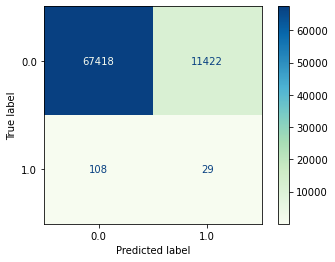

In [29]:
# Confusion Matrix
cm = confusion_matrix(list(y_test), y_preds, labels=om_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=om_pipeline.classes_)
disp.plot(cmap='GnBu')
plt.show()

# Save optimal model

In [30]:
model_file = '/data/home/bt211037/dissertation/all_feats_rf_model.pkl'

In [31]:
pickle.dump(om_pipeline, open(model_file, 'wb'))

# SHAP Analysis 

In [32]:
rf_model = pickle.load(open('/data/home/bt211037/dissertation/all_feats_rf_model.pkl', 'rb'))

In [33]:
rf_model

Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  [5, 6, 7, 11, 12, 14, 15, 17,
                                                   20, 25, 31, 32, 33, 34, 35,
                                                   54, 55, 56, 57, 68, 70, 73,
                                                   74, 77, 114, 135, 136, 137,
                                                   144, 145, ...]),
                                                 ('cat',
                                                  SimpleImputer(fill_value=4444,
                                                                strategy='constant'),
                                                  [0, 1, 2, 3, 4, 8, 9, 10, 13,
                                                   16, 18, 19, 21, 22, 23, 24,
                                                   26, 27, 28, 29, 30, 36, 37,
                                                   38, 39, 40, 41, 42, 43, 44, ...])])),
                ('tomek', TomekLinks(sampling_strategy='majority')),
                ('smotenc',
                 SMOTENC(categorical_features=[0, 1, 2, 3, 4, 8, 9, 10, 13, 16,
                                               18, 19, 21, 22, 23, 24, 26, 27,
                                               28, 29, 30, 36, 37, 38, 39, 40,
                                               41, 42, 43, 44, ...],
                         random_state=14, sampling_strategy=1)),
                ('model',
                 ExtraTreesClassifier(max_depth=5, max_features=15,
                                      n_estimators=200, n_jobs=10,
                                      random_state=14))])

In [34]:
def shap_prepro(model, X, y, enc=True):
    
    # Imputation
    imp = model.named_steps['imputer'].fit_transform(X)
    # Encoding & Normalisation
    if enc:
        en_norm = model.named_steps['enc_norm'].fit_transform(imp) 
        # Tomek
        tomek_x, tomek_y = model.named_steps['tomek'].fit_resample(en_norm, y)
        # SMOTE
        smote_x, smote_y = model.named_steps['smotenc'].fit_resample(tomek_x, tomek_y)
        
    else:
        
        tomek_x, tomek_y = model.named_steps['tomek'].fit_resample(imp, y)
        # SMOTE
        smote_x, smote_y = model.named_steps['smotenc'].fit_resample(tomek_x, tomek_y)
        
        

    return smote_x, smote_y
    

In [35]:
X_shap, y_shap = shap_prepro(rf_model, X_res, y_res, False)

In [36]:
explainer = shap.TreeExplainer(rf_model.named_steps['model'])

In [37]:
shap_values = explainer.shap_values(X_shap, approximate=False, check_additivity=False)

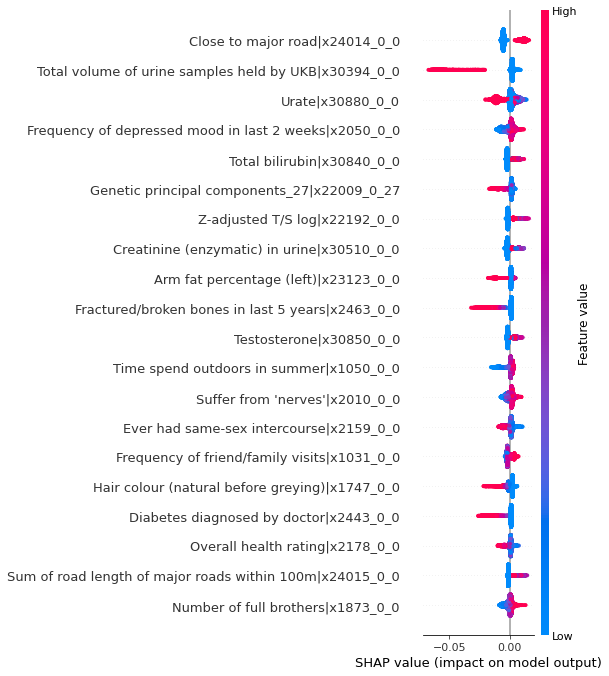

In [38]:
fig = shap.summary_plot(shap_values[1], X_shap, feature_names=list(X_train.columns))